## Starcraft 2 Unsupervised League Classification

<img src= "https://c4.wallpaperflare.com/wallpaper/226/198/422/spaceships-battlecruiser-blizzard-entertainment-sciencefiction-starcraft-ii-2048x1160-video-games-starcraft-hd-art-wallpaper-preview.jpg" style='width: 600px;'>

## Problem Statement

**Starcraft 2** is an RTS that has a ranking system of its own. Each ranked players are associated with one of the seven leagues.

But are these seven leagues split in a **statistically reasonable manner?** Should there be **more or less number of leagues to correctly make a group following each player's skills?**

And that is the problem that I'm going to tackle today, by using **k-means clustering,** and finding the optimal value for k.

I will use **PCA** to decrease the dimension of the data, to reduce the performance of clustering and visualize it better.

## Enviroment Setup

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew

## Basic EDA & Data Cleaning

In [236]:
data_original = pd.read_csv('../input/skillcraft/SkillCraft.csv')

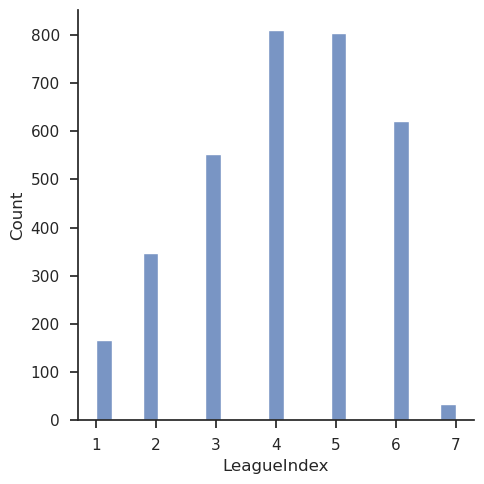

In [237]:
sns.displot(data=data_original, x="LeagueIndex")

### Examining the distribution plot of the reference feature

The distribution looks a bit skewed to the right, with much higher number of players in league 4 and 5, and the smallest number of players in the highest league, league 7.

Assuming that this classification of players' skill are correct, the result of the clustering should show the best performance at **k=7,** and that is what I will be testing for in this analysis.

Now, let's do some additional EDA plus data cleaning.

In [238]:
data_original.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


### Examining the head of the dataset

There are 20 features including the **GameID** column, with the reference feature of this problem : **LeagueIndex.**

The reference feature's column will not be used for clustering, and will be removed.

Since the first column is insignificant for clustering, it will also be removed.

In [239]:
data = data_original.drop(['GameID', 'LeagueIndex'], axis = 1)

In [240]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338 entries, 0 to 3337
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   3338 non-null   int64  
 1   HoursPerWeek          3338 non-null   int64  
 2   TotalHours            3338 non-null   int64  
 3   APM                   3338 non-null   float64
 4   SelectByHotkeys       3338 non-null   float64
 5   AssignToHotkeys       3338 non-null   float64
 6   UniqueHotkeys         3338 non-null   int64  
 7   MinimapAttacks        3338 non-null   float64
 8   MinimapRightClicks    3338 non-null   float64
 9   NumberOfPACs          3338 non-null   float64
 10  GapBetweenPACs        3338 non-null   float64
 11  ActionLatency         3338 non-null   float64
 12  ActionsInPAC          3338 non-null   float64
 13  TotalMapExplored      3338 non-null   int64  
 14  WorkersMade           3338 non-null   float64
 15  UniqueUnitsMade      

### Examining the dimension of the data

Now there are **3338** entries in the dataset with 18 feature columns, and there's **no null or string values.**

Now, let's look at the skewness of each feature.

In [241]:
skewness = skew(data, axis=0)

for i, s in enumerate(skewness):
    print("Skewness of {}: {:.2f}".format(data.columns[i], s))

Skewness of Age: 1.15
Skewness of HoursPerWeek: 2.67
Skewness of TotalHours: 57.54
Skewness of APM: 0.99
Skewness of SelectByHotkeys: 2.98
Skewness of AssignToHotkeys: 0.83
Skewness of UniqueHotkeys: 0.20
Skewness of MinimapAttacks: 5.15
Skewness of MinimapRightClicks: 2.22
Skewness of NumberOfPACs: 0.50
Skewness of GapBetweenPACs: 1.95
Skewness of ActionLatency: 1.20
Skewness of ActionsInPAC: 1.61
Skewness of TotalMapExplored: 0.63
Skewness of WorkersMade: 1.66
Skewness of UniqueUnitsMade: 0.19
Skewness of ComplexUnitsMade: 2.28
Skewness of ComplexAbilitiesUsed: 3.80


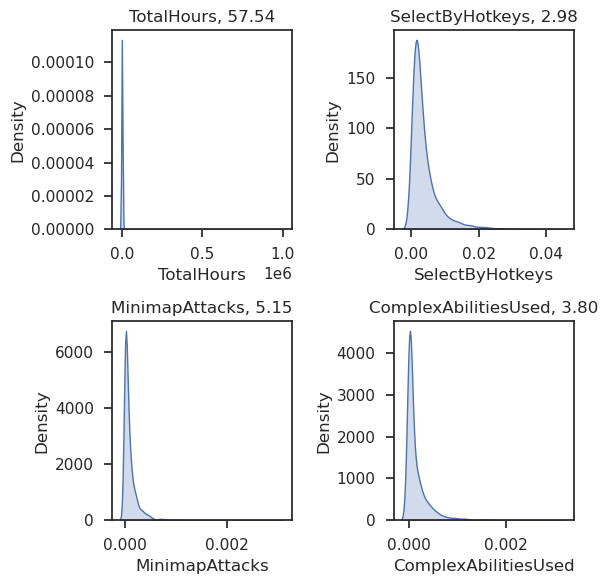

In [242]:
threshold = 2.75

selected_features = [col_name for col_name, s in zip(data.columns, skewness) if abs(s) > threshold]

sns.set(style="ticks")

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for i, col_name in enumerate(selected_features):
    row = i // 2
    col = i % 2
    
    sns.kdeplot(data[col_name], fill=True, ax=axs[row, col])
    
    axs[row, col].set_title("{}, {:.2f}".format(col_name, skewness[data.columns.get_loc(col_name)]))
    
plt.tight_layout()

plt.show()

### Examining the skewness of each feature

Most of the data is skewed to the left, but this is just natural if I think about the nature of competitive gaming. 

The parameters won't be strictly normal most of the times, and will be **skewed to the right,** since many competitive players who excel at gaming will always act as an outlier at the right (higher) side.

But even considering this fact, the TotalHours feature's skewness is **extremely high,** and since I do not think this feature will always help in classifying each player's skill, I will remove this column.

In [243]:
data = data_original.drop(['GameID', 'LeagueIndex', 'TotalHours'], axis = 1)

In [244]:
z_scores = np.abs((data - data.mean()) / data.std())

threshold = 3

outliers = np.where(z_scores > threshold)

data_clean = data[(z_scores <= threshold).all(axis=1)]

print("Number of outliers removed:", data.shape[0] - data_clean.shape[0])

data = data_clean

Number of outliers removed: 601


In [245]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2737 entries, 0 to 3337
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   2737 non-null   int64  
 1   HoursPerWeek          2737 non-null   int64  
 2   APM                   2737 non-null   float64
 3   SelectByHotkeys       2737 non-null   float64
 4   AssignToHotkeys       2737 non-null   float64
 5   UniqueHotkeys         2737 non-null   int64  
 6   MinimapAttacks        2737 non-null   float64
 7   MinimapRightClicks    2737 non-null   float64
 8   NumberOfPACs          2737 non-null   float64
 9   GapBetweenPACs        2737 non-null   float64
 10  ActionLatency         2737 non-null   float64
 11  ActionsInPAC          2737 non-null   float64
 12  TotalMapExplored      2737 non-null   int64  
 13  WorkersMade           2737 non-null   float64
 14  UniqueUnitsMade       2737 non-null   int64  
 15  ComplexUnitsMade     

### Removing outliers

Next, I removed some outliers based on the z-score, and the cleaned data for clustering now has **17 columns, and 2737 non-null entries.**

Finally, I will examine the correlation matrix for the cleaned data, and finalize the data cleaning process if it looks good.

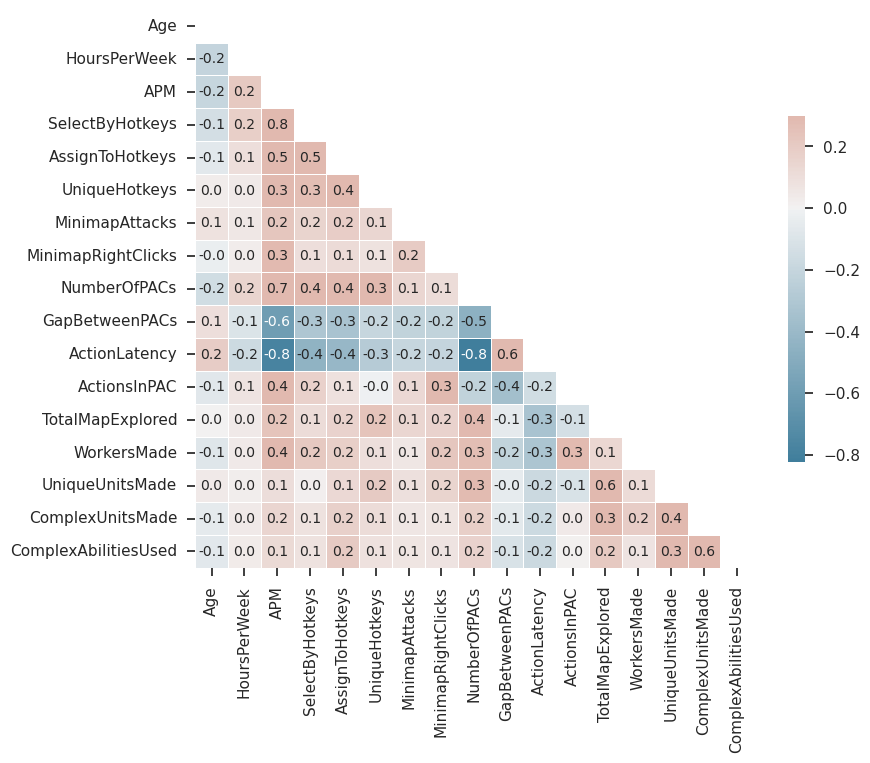

In [246]:
corr = data.corr()

fig, axis = plt.subplots(figsize=(9, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f",
            annot_kws={"fontsize": 10})

plt.show()

### Examining the correlation plot

There are some closely-correlated features visible, but I see **no linear combination between the features.** I will be less strict here because this is a clustering problem, and not regression analysis.

## Performing PCA on Cleaned Data

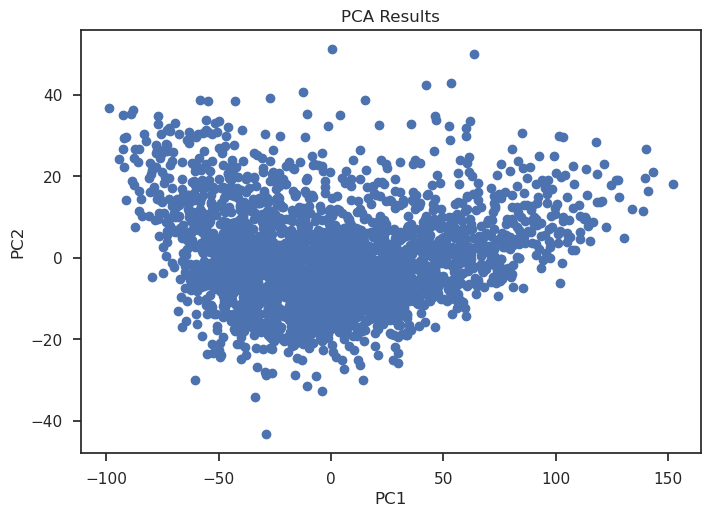

Loadings of PC1:  [-1.78785661e-02  4.86783106e-02  9.21160322e-01  5.75414422e-05
  2.18004808e-06  1.63890479e-02  5.50019163e-07  1.89240412e-06
  1.42982226e-05 -2.17915055e-01 -3.14925170e-01  1.24765090e-02
  4.07423176e-02  4.17647282e-06  5.04005415e-03  3.12280229e-07
  5.26505136e-07]
Loadings of PC2:  [-7.95457817e-03  8.81189126e-02  3.43505824e-01  9.39258847e-05
 -8.88730964e-08 -1.76107700e-03 -6.27316127e-07 -2.03372316e-07
 -1.34244702e-05  8.14755626e-01  4.58023877e-01  7.25367551e-03
  2.20224287e-02  2.65384598e-06 -4.71327704e-03  7.84203735e-08
 -1.09184335e-06]


In [247]:
pca = PCA(n_components=2)

data_pca = pca.fit_transform(data)

plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.title("PCA Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

loadings = pca.components_

print("Loadings of PC1: ", loadings[0])
print("Loadings of PC2: ", loadings[1])

### Examining the PCA results

The data points seem to be well-distributed, but they are not that apart from each other.

The distribution looks like an upside-down trapezoid, and the feature that had the largest weight in the first principal component was **APM,** and the most significant feature in the second principal component was **GapBetweenPACs.** Both features are indeed an important metric for gaming skills, and I think the PCA went well.

Now, let's do the clustering.

## Performing K-Means Clustering on PCA Output

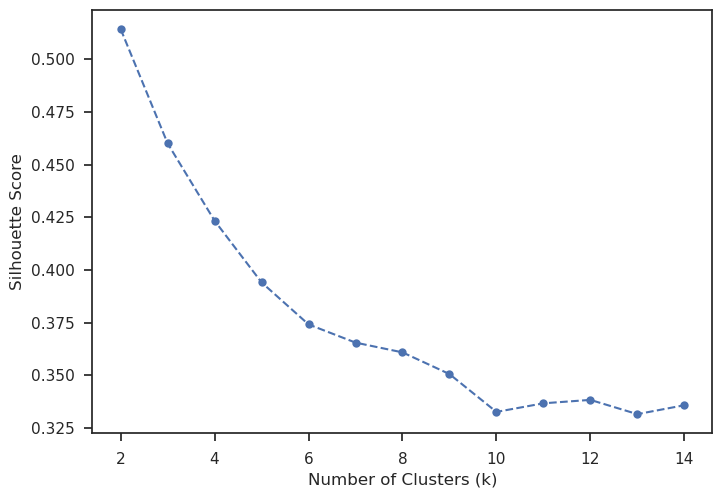

In [248]:
ks = range(2, 15)

sil_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_pca)
    sil_score = silhouette_score(data_pca, kmeans.labels_)
    sil_scores.append(sil_score)

plt.plot(ks, sil_scores, 'o--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

### Examining the silhouette score plot

Based on the plot, it can be seen that the silhouette score decreases sharply across the first clusters, and its slope starts to go smooth at **k=7,** and descends until **k=10.**

Based only on this plot, it can be said that **k=10** is the best number of groups when only considering the metric, but let's take a look at some more detailed visualizations.

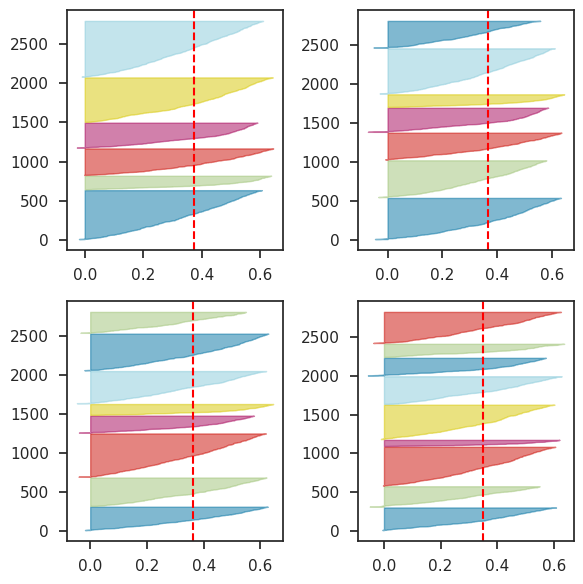

In [249]:
ks = range(6, 10)

fig, axis = plt.subplots(2, 2, figsize=(6, 6))

for k in ks:
    km = KMeans(n_clusters=k)
    
    q, mod = divmod(k - 4, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=axis[q-1][mod])
    
    visualizer.fit(data_pca)
    
plt.tight_layout()

plt.show()

### Examining the silhouette score visualization for k=6, k=7, k=8, k=9

It can be seen that the shape of each group inside the plot are very far from being square, and this means that the data points inside each group are not densely packed right next to each other.

From this plot, it can be said that the players' skills are very well distributed, with low difference in density across the data points.

Also, **k=7** looks like the best number of groups in terms of having consistent group sizes, with a low enough silhouette score.

**k=8** looks good too, but some of the groups' sizes are very small, not making it quite practical.

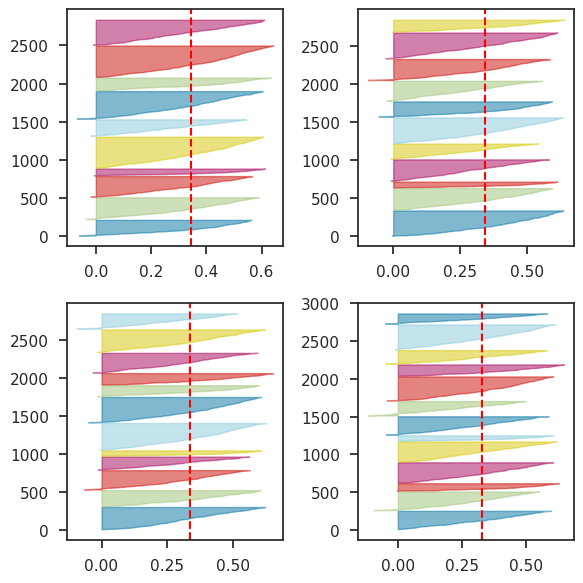

In [250]:
ks = range(10, 14)

fig, axis = plt.subplots(2, 2, figsize=(6, 6))

for k in ks:
    km = KMeans(n_clusters=k)
    
    q, mod = divmod(k - 8, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=axis[q-1][mod])
    
    visualizer.fit(data_pca)
    
plt.tight_layout()

plt.show()

### Examining the silhouette score visualization for k=10, k=11, k=12, k=13

They have **less consistent group sizes** compared to the previous plot overall. 

Even if they are more statistically correct, too much group sizes will make the league system less intuitive to the players, making it harder to remember.

## Conclusion

Based on these evaluation metrics, I conclude that **k=7** is the best number of groups in terms of grouping players based on their gaming skills fairly, and practically.

Since both the number of groups in a competitive league and the grouping style are closely related to **player engagement** in real life, there's always some adjustments that should be made. This makes the choice of **seven groups** made by developers at Blizzard a valid, practical choice, even if there could be group sizes that can classify the players better statistically.

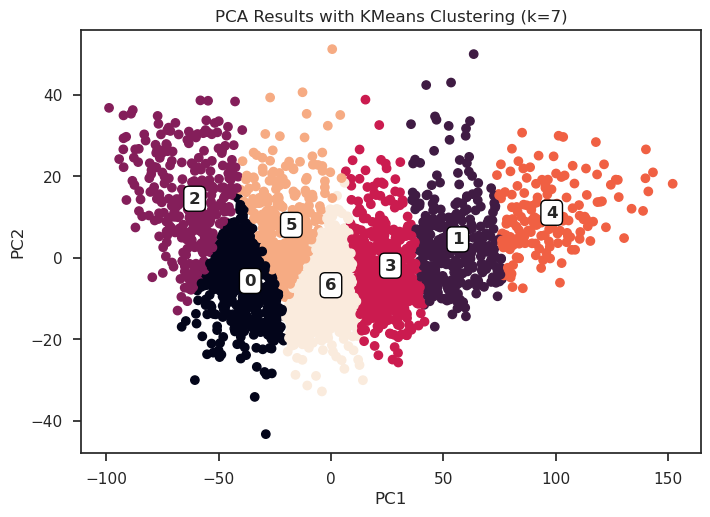

In [251]:
kmeans = KMeans(n_clusters=7)

labels = kmeans.fit_predict(data_pca)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)
plt.title("PCA Results with KMeans Clustering (k=7)")
plt.xlabel("PC1")
plt.ylabel("PC2")

centroids = kmeans.cluster_centers_

for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], str(i), fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.show()